
# Step 7 — Fast Post-Evaluation & Analysis

This accelerated version is designed for **~minutes to a couple of hours**, not days.

**What it does:**
- Parses the JSONL once (fast).
- **Intrinsic metrics** on the full set (fast).
- **Semantic redundancy** with **FAISS HNSW** (approximate, fast) + **embedding cache**.
- **Reader evaluation** on a **sample** (stratified), with GPU inference and batching.
- Saves results to CSV for reuse.


In [1]:

# CONFIG
from pathlib import Path

# Data
QA_JSONL = Path("/mnt/data/QA Generation Pipeline results/3gpp_testing.jsonl")

# Sampling knobs
SAMPLE_N_EVAL = 10000          # number of QA pairs to run the reader on
SAMPLE_N_REDUNDANCY = 50000    # number of questions to use for redundancy analysis
RANDOM_SEED = 42

# Reader model
MODEL_PATH = "/home/ec2-user/qa_roberta_telecom"  
DEVICE = 0  

# Context truncation for speed 
CONTEXT_CHARS = 1500

# Embedding cache
EMB_CACHE = Path("q_emb.npy")
Q_CACHE   = Path("questions.pkl")

# FAISS HNSW knobs
HNSW_M = 32            
HNSW_EF_CONSTRUCT = 200
HNSW_EF_SEARCH = 64


print("Config loaded.")

Config loaded.


In [2]:

import json, re, math, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def normalize(text):
    return re.sub(r"\s+", " ", (text or "").strip().lower())

PAT = re.compile(
    r"### Context:\s*(.*?)\s*### Question:\s*(?:question:\s*)?(.*?)\s*### Answer:\s*\[/INST\]\s*(.*?)\s*(?:</s>|$)",
    re.DOTALL | re.IGNORECASE
)

def parse_triple(text):
    m = PAT.search(text or "")
    if not m:
        return ("", "", "")
    ctx, q, a = [s.strip() for s in m.groups()]
    return ctx, q, a

# Load JSONL
qa_data = [json.loads(line) for line in QA_JSONL.open("r", encoding="utf-8")]
len(qa_data)


218347

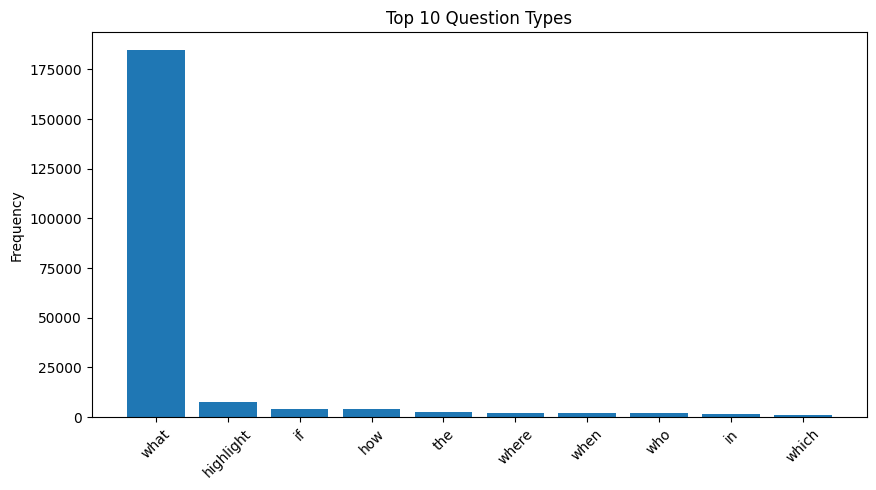

=== Intrinsic QA Evaluation Summary ===


,Metric,Value
0,Total QA Pairs,218347.000
1,Answer in Context (%),100.000
2,Unique Questions (%),71.880
3,Unique Answers (%),51.660
4,Avg. Answer Position in Context,0.267
5,Avg. Answer Span % of Context,0.034


In [3]:

total_pairs = len(qa_data)
answer_in_context_count = 0
unique_questions, unique_answers = set(), set()
question_types, answer_positions, answer_spans = [], [], []
context_lengths, answer_lengths = [], []

for item in qa_data:
    ctx, q, ans = parse_triple(item.get("text",""))
    nc, na = normalize(ctx), normalize(ans)

    if na and na in nc:
        answer_in_context_count += 1
        idx = nc.find(na)
        if idx >= 0 and len(nc) > 0:
            answer_positions.append(idx / len(nc))
            answer_spans.append(len(na) / len(nc))

    if q:
        qq = q
        if qq.lower().startswith("question:"):
            qq = qq[len("question:"):].strip()
        tok0 = re.split(r"[^\w]+", qq.strip(), maxsplit=1)[0].lower() if qq.strip() else ""
        if tok0:
            question_types.append(tok0)
        unique_questions.add(qq)
    if ans:
        unique_answers.add(ans)

    context_lengths.append(len((ctx or "").split()))
    answer_lengths.append(len((ans or "").split()))

summary = pd.DataFrame({
    "Metric": [
        "Total QA Pairs",
        "Answer in Context (%)",
        "Unique Questions (%)",
        "Unique Answers (%)",
        "Avg. Answer Position in Context",
        "Avg. Answer Span % of Context"
    ],
    "Value": [
        total_pairs,
        round(answer_in_context_count / max(total_pairs,1) * 100, 2),
        round(len(unique_questions) / max(total_pairs,1) * 100, 2),
        round(len(unique_answers) / max(total_pairs,1) * 100, 2),
        round(pd.Series(answer_positions).mean(), 3) if answer_positions else None,
        round(pd.Series(answer_spans).mean(), 3) if answer_spans else None
    ]
})

# Plot
qt_counts = Counter(question_types)
if qt_counts:
    qt_df = (pd.DataFrame(qt_counts.items(), columns=["Question Type","Count"])
             .sort_values("Count", ascending=False))
    plt.figure(figsize=(10,5))
    plt.bar(qt_df["Question Type"][:10], qt_df["Count"][:10])
    plt.title("Top 10 Question Types")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No question types parsed.")

print("=== Intrinsic QA Evaluation Summary ===")
summary

In [4]:
rows = []
for item in qa_data:
    ctx, q, ans = parse_triple(item.get("text",""))
    if ctx and q and ans:
        rows.append({"context": ctx, "question": q, "gold_answer": ans})
full_df = pd.DataFrame(rows)
print("Full parsed triples:", len(full_df))

Full parsed triples: 218347


In [5]:

rng = np.random.default_rng(RANDOM_SEED)

tmp = full_df.copy()
tmp["qtype"] = tmp["question"].str.strip().str.split().str[0].str.lower().fillna("")
tmp["ans_len"] = tmp["gold_answer"].fillna("").str.split().map(len)
# 5 quantile bins
ans_bins = pd.qcut(tmp["ans_len"].clip(lower=0), q=5, duplicates="drop")
tmp["ans_bin"] = ans_bins.astype(str)

groups = tmp.groupby(["qtype","ans_bin"])
# proportional allocation with a minimum of 3 per stratum
alloc = (groups.size() / len(tmp) * SAMPLE_N_EVAL).round().astype(int).clip(lower=3)

sample_idx = []
for key, n in alloc.items():
    g = groups.get_group(key)
    take = min(len(g), int(n))
    if take > 0:
        idx = rng.choice(g.index.values, size=take, replace=False)
        sample_idx.extend(idx.tolist())

if len(sample_idx) > SAMPLE_N_EVAL:
    sample_idx = rng.choice(sample_idx, size=SAMPLE_N_EVAL, replace=False).tolist()
elif len(sample_idx) < SAMPLE_N_EVAL:
    remaining = list(set(tmp.index) - set(sample_idx))
    add = rng.choice(remaining, size=SAMPLE_N_EVAL - len(sample_idx), replace=False).tolist()
    sample_idx.extend(add)

eval_df = full_df.loc[sorted(sample_idx)].reset_index(drop=True)
print("Evaluation sample size:", len(eval_df))


Evaluation sample size: 10000


In [6]:

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import torch
from tqdm import tqdm
kwargs = {}
if DEVICE >= 0:
    kwargs.update(dict(torch_dtype=torch.float16, device_map=None))
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

qa = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer,
    device=DEVICE
)

# Batched inference
BATCH = 64
preds = []
for i in tqdm(range(0, len(eval_df), BATCH)):
    batch = eval_df.iloc[i:i+BATCH]
    inputs = [
        {"question": q, "context": c[:CONTEXT_CHARS]}  # quick truncation for speed
        for q, c in zip(batch["question"].tolist(), batch["context"].tolist())
    ]
    outs = qa(inputs)
    # pipeline returns a dict or list of dicts depending on input type
    if isinstance(outs, dict):
        outs = [outs]
    preds.extend([o.get("answer","") for o in outs])

eval_df["predicted_answer"] = preds

# SQuAD-style EM/F1
from collections import Counter
def normalize_space(s): return re.sub(r"\s+", " ", (s or "").strip().lower())
def f1_score(pred, gold):
    ptoks = normalize_space(pred).split()
    gtoks = normalize_space(gold).split()
    if len(ptoks)==0 and len(gtoks)==0: return 1.0
    if len(ptoks)==0 or len(gtoks)==0:  return 0.0
    common = sum((Counter(ptoks) & Counter(gtoks)).values())
    if common == 0: return 0.0
    prec = common / len(ptoks)
    rec  = common / len(gtoks)
    return 2*prec*rec/(prec+rec)

eval_df["em"] = (eval_df["predicted_answer"].map(normalize_space) == eval_df["gold_answer"].map(normalize_space)).astype(int)
eval_df["f1"] = [f1_score(p,g) for p,g in zip(eval_df["predicted_answer"], eval_df["gold_answer"])]

print("\n=== Sampled QA Evaluation Results ===")
print(f"Total evaluated: {len(eval_df)}")
print(f"Exact Match (EM): {eval_df['em'].mean():.4f}")
print(f"F1 Score:          {eval_df['f1'].mean():.4f}")

eval_df.to_csv("qa_eval_results_SAMPLE.csv", index=False)
print("Saved qa_eval_results_SAMPLE.csv")


Device set to use cuda:0
  0%|                                                   | 0/157 [00:00<?, ?it/s]/home/ec2-user/.local/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:390: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
  4%|█▋                                         | 6/157 [00:04<01:56,  1.30it/s]/home/ec2-user/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:718: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f9048499250> was reported to be 64(when accessing len(dataloader)), but 65 samples have been fetched. 
  warnings.warn(warn_msg)
/home/ec2-user/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:718: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator objec


=== Sampled QA Evaluation Results ===
Total evaluated: 10000
Exact Match (EM): 0.9535
F1 Score:          0.9767
Saved qa_eval_results_SAMPLE.csv


In [8]:
eval_df.head()

,context,question,gold_answer,predicted_answer,em,f1
0,and evolution should consider supporting energ...,What should be considered supporting energy sa...,and evolution,and evolution,1,1.0
1,Equipment (TE)). Mobile evaluated handover: Mo...,What does MEHO stand for?,Mobile evaluated handover,Mobile evaluated handover,1,1.0
2,subset of (U)SIMs Network termination: A funct...,What is a subset of (U)SIMs Network termination?,A functional group on the network side of a us...,A functional group on the network side of a us...,1,1.0
3,in which a fixed network user can call a mobil...,What is a service attribute?,A specified characteristic of a telecommunicat...,A specified characteristic of a telecommunicat...,1,1.0
4,"5GC requirements (e.g. Ethernet traffic, QoS f...",What is the 5GC requirement?,"Ethernet traffic, QoS flows","Ethernet traffic, QoS flows",1,1.0


In [9]:
print("Rows:", len(eval_df))
print(eval_df[["f1","em"]].describe().T)
print("Nulls:", eval_df.isna().sum().to_dict())

Rows: 10000
      count      mean       std  min  25%  50%  75%  max
f1  10000.0  0.976733  0.131542  0.0  1.0  1.0  1.0  1.0
em  10000.0  0.953500  0.210576  0.0  1.0  1.0  1.0  1.0
Nulls: {'context': 0, 'question': 0, 'gold_answer': 0, 'predicted_answer': 0, 'em': 0, 'f1': 0}


In [10]:
import numpy as np, pandas as pd
def bootstrap_ci(col, B=1000, seed=42):
    v = pd.Series(col).dropna().values
    rng = np.random.default_rng(seed)
    sims = [rng.choice(v, size=len(v), replace=True).mean() for _ in range(B)]
    return np.percentile(sims, [2.5, 97.5])

print("EM mean:", eval_df["em"].mean(), "95% CI:", bootstrap_ci(eval_df["em"]))
print("F1 mean:", eval_df["f1"].mean(), "95% CI:", bootstrap_ci(eval_df["f1"]))

EM mean: 0.9535 95% CI: [0.9495975 0.9575   ]
F1 mean: 0.9767327573649036 95% CI: [0.97417815 0.97916839]


In [11]:
import re
def norm_lower_ws(s):  return re.sub(r"\s+"," ",str(s).strip().lower())
def norm_alnum(s):     return re.sub(r"[^a-z0-9]+"," ",str(s).strip().lower()).strip()

em_exact = (eval_df["predicted_answer"] == eval_df["gold_answer"]).astype(int).mean()
em_lower = (eval_df["predicted_answer"].map(norm_lower_ws) == eval_df["gold_answer"].map(norm_lower_ws)).astype(int).mean()
em_alnum = (eval_df["predicted_answer"].map(norm_alnum) == eval_df["gold_answer"].map(norm_alnum)).astype(int).mean()

print(f"EM (exact): {em_exact:.3f} | EM (lower+ws): {em_lower:.3f} | EM (alnum-only): {em_alnum:.3f}")

EM (exact): 0.954 | EM (lower+ws): 0.954 | EM (alnum-only): 0.963


In [12]:
eval_df["qtype"] = eval_df["question"].str.split().str[0].str.lower()
qtype_perf = (eval_df.groupby("qtype")[["f1","em"]]
              .mean().sort_values("f1", ascending=False))
display(qtype_perf.head(12))
display(qtype_perf.tail(12))

,f1,em
qtype,,
!--,1.0,1.0
ndub,1.0,1.0
multi-universal,1.0,1.0
multicast,1.0,1.0
multimedia,1.0,1.0
multiplexing,1.0,1.0
n,1.0,1.0
n+t3,1.0,1.0
n.2.2.2,1.0,1.0


,f1,em
qtype,,
on-demand,0.0,0.0
combinations,0.0,0.0
s11-u,0.0,0.0
versions,0.0,0.0
scps,0.0,0.0
21,0.0,0.0
navailable,0.0,0.0
secam,0.0,0.0
session,0.0,0.0


In [13]:
eval_df["ans_len"] = eval_df["gold_answer"].fillna("").str.split().map(len)
eval_df["ctx_len"] = eval_df["context"].fillna("").str.split().map(len)

print("F1 by answer length (quantiles):")
print(eval_df.groupby(pd.qcut(eval_df["ans_len"], 5, duplicates="drop"))["f1"].mean())

print("\nF1 by context length (quantiles):")
print(eval_df.groupby(pd.qcut(eval_df["ctx_len"], 5, duplicates="drop"))["f1"].mean())

F1 by answer length (quantiles):
ans_len
(0.999, 2.0]    0.940351
(2.0, 4.0]      0.987755
(4.0, 5.0]      0.987491
(5.0, 8.0]      0.987566
(8.0, 15.0]     0.990348
Name: f1, dtype: float64

F1 by context length (quantiles):
ctx_len
(3.999, 150.0]    0.976733
Name: f1, dtype: float64


/tmp/ipykernel_7415/938009354.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(eval_df.groupby(pd.qcut(eval_df["ans_len"], 5, duplicates="drop"))["f1"].mean())
/tmp/ipykernel_7415/938009354.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(eval_df.groupby(pd.qcut(eval_df["ctx_len"], 5, duplicates="drop"))["f1"].mean())


In [14]:
def gold_pos(row):
    c = str(row["context"]).lower(); a = str(row["gold_answer"]).lower()
    i = c.find(a)
    return None if i < 0 or len(c)==0 else i/len(c)
eval_df["gold_pos"] = eval_df.apply(gold_pos, axis=1)

print("Avg gold position:", eval_df["gold_pos"].mean())
print("F1 by gold_pos terciles:")
print(eval_df.groupby(pd.qcut(eval_df["gold_pos"], 3, duplicates="drop"))["f1"].mean())

Avg gold position: 0.2652470471810833
F1 by gold_pos terciles:
gold_pos
(-0.001, 0.0685]    0.984932
(0.0685, 0.308]     0.978437
(0.308, 0.996]      0.966830
Name: f1, dtype: float64


/tmp/ipykernel_7415/268442092.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(eval_df.groupby(pd.qcut(eval_df["gold_pos"], 3, duplicates="drop"))["f1"].mean())


In [15]:
import re
def has_digits(s):     return bool(re.search(r"\d", str(s)))
def has_underscore(s): return "_" in str(s)
def has_hyphen(s):     return "-" in str(s)
def has_acronym(s):    return bool(re.search(r"\\b[A-Z]{2,}\\b", str(s)))

for name, fn in [("digits",has_digits),("underscore",has_underscore),
                 ("hyphen",has_hyphen),("acronym",has_acronym)]:
    m = eval_df["gold_answer"].map(fn)
    print(f"{name:10s} -> N={m.sum():4d} | F1={eval_df.loc[m,'f1'].mean():.3f} | EM={eval_df.loc[m,'em'].mean():.3f}")

digits     -> N=1560 | F1=0.938 | EM=0.910
underscore -> N= 208 | F1=0.969 | EM=0.952
hyphen     -> N= 943 | F1=0.982 | EM=0.952
acronym    -> N=   0 | F1=nan | EM=nan


In [16]:
print("Top patterns in wrong cases:")
wrong = eval_df[eval_df["em"]==0].copy()

# near-miss: high F1 but EM=0 (formatting/extra tokens)
near_miss = wrong[wrong["f1"]>=0.7]
print("Near-miss %:", len(near_miss)/max(len(eval_df),1))

# empty predictions
empty_pred = wrong[wrong["predicted_answer"].fillna("").str.strip()==""]
print("Empty prediction %:", len(empty_pred)/max(len(eval_df),1))

# numeric mismatch
num_gold = wrong["gold_answer"].str.contains(r"\\d", regex=True, na=False)
print("Numeric-in-gold error %:", num_gold.mean())

Top patterns in wrong cases:
Near-miss %: 0.0185
Empty prediction %: 0.0
Numeric-in-gold error %: 0.0


In [17]:
def show_rows(df, k=3):
    for _,r in df.head(k).iterrows():
        print("-"*80)
        print("Q:", r["question"])
        print("Gold:", r["gold_answer"])
        print("Pred:", r["predicted_answer"])
        print("F1:", round(r["f1"],3), "EM:", r["em"])

print("WORST CASES:")
show_rows(eval_df.sort_values("f1").reset_index(drop=True), k=5)

print("\\nBEST CASES:")
show_rows(eval_df.sort_values("f1", ascending=False).reset_index(drop=True), k=5)

WORST CASES:
--------------------------------------------------------------------------------
Q: ATCF interacts with ATGW to provide media related information.
Gold: NOTE 5
Pred: provided by the ATGW
F1: 0.0 EM: 0
--------------------------------------------------------------------------------
Q: 21 octets apply only in case of SACCH.
Gold: NOTE
Pred: SACCH and SDCCH
F1: 0.0 EM: 0
--------------------------------------------------------------------------------
Q: S11-U is the interface between Mobile Management Entity (MME) and combined SGW/PGW-U.
Gold: NOTE 2
Pred: Combined SGW/PGW architecture.
F1: 0.0 EM: 0
--------------------------------------------------------------------------------
Q: What is the name of the requester?
Gold: plmn-list
Pred: snssais
F1: 0.0 EM: 0
--------------------------------------------------------------------------------
Q: HO_MARGIN(n) defines the location of timer start.
Gold: NOTE 4
Pred: still in the coverage area of that cell
F1: 0.0 EM: 0
\nBEST CASES

In [18]:
dupe_rate = 1 - eval_df["question"].str.lower().str.strip().nunique() / len(eval_df)
print(f"Exact-duplicate question rate (sample): {dupe_rate:.3%}")

Exact-duplicate question rate (sample): 7.520%
